## Setup


In [1]:
import numpy as np
from type_definitions.utils import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Simulation


In [2]:
seed = 100

np.random.seed(seed)

# Generate cases with constraint on velocity angle difference
# Constrain to cases where angle between ownship and intruder velocities is within range
# This reduces the number of cases and makes distance matrix calculation faster
# Range: π/6 to π/2 (30 to 90 degrees) - focuses on convergent/conflict scenarios
velocity_angle_diff_range = (np.pi / 6, np.pi / 3)

# Generate fewer cases since we're filtering
cases = generate_acasxu_dubins_cases(
    1000,
    intruder_can_turn=True,
    velocity_angle_diff_range=velocity_angle_diff_range,  # Reduced from 100000
)
results = evaluate_acasxu_dubins_cases(cases)
# Extract ownship trajectories (aircraft 0) from valid results
trajectories = [
    extract_acasxu_dubins_trajectory(r, aircraft_index=0)
    for r in results
    if not r.simulation_failed
]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Collisions: {sum(1 for r in valid_results if r.collision_occurred)}, Safe: {sum(1 for r in valid_results if not r.collision_occurred)}"
)
print(f"Min separation: {min([r.min_separation for r in valid_results]):.2f} ft")
print(
    f"Average min separation: {np.mean([r.min_separation for r in valid_results]):.2f} ft"
)

Generated 1000 valid trajectories
Collisions: 0, Safe: 1000
Min separation: 584.89 ft
Average min separation: 20429.39 ft


In [3]:
# Analyze collision scenarios
collision_results = [r for r in valid_results if r.collision_occurred]
print(f"Collision scenarios: {len(collision_results)}")
if len(collision_results) > 0:
    print(
        f"  Average min separation in collisions: {np.mean([r.min_separation for r in collision_results]):.2f} ft"
    )
    print(
        f"  Min separation in collisions: {min([r.min_separation for r in collision_results]):.2f} ft"
    )

# Analyze safe scenarios
safe_results = [r for r in valid_results if not r.collision_occurred]
print(f"\nSafe scenarios: {len(safe_results)}")
if len(safe_results) > 0:
    print(
        f"  Average min separation: {np.mean([r.min_separation for r in safe_results]):.2f} ft"
    )
    print(f"  Min separation: {min([r.min_separation for r in safe_results]):.2f} ft")
    print(f"  Max separation: {max([r.min_separation for r in safe_results]):.2f} ft")

# Check for safety limit violations
violated_results = [r for r in valid_results if r.violated_safety_limits]
print(f"\nSafety limit violations: {len(violated_results)}")

Collision scenarios: 0

Safe scenarios: 1000
  Average min separation: 20429.39 ft
  Min separation: 584.89 ft
  Max separation: 34909.86 ft

Safety limit violations: 0


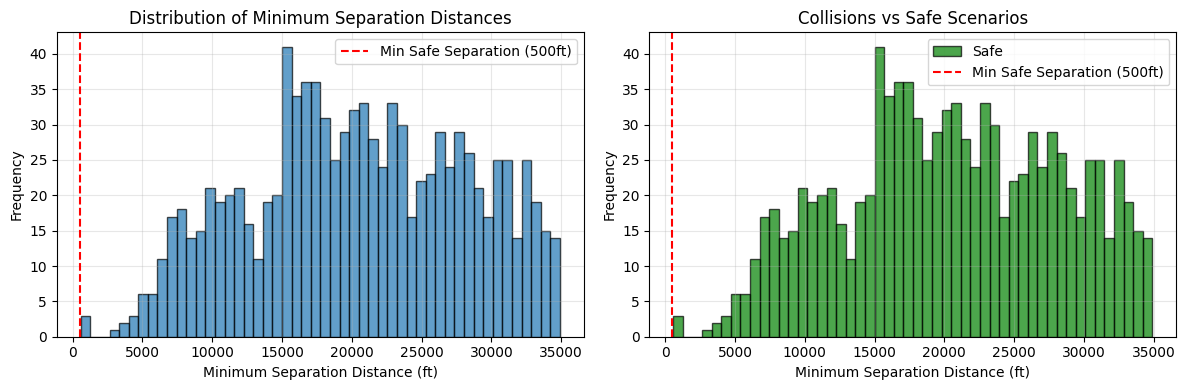

In [4]:
# Plot separation distance histogram
separations = [r.min_separation for r in valid_results]
collision_separations = (
    [r.min_separation for r in collision_results] if len(collision_results) > 0 else []
)
safe_separations = [r.min_separation for r in safe_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of all separations
ax1.hist(separations, bins=50, alpha=0.7, edgecolor="black")
ax1.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax1.set_xlabel("Minimum Separation Distance (ft)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Minimum Separation Distances")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Separate histograms for collisions vs safe
if len(collision_separations) > 0:
    ax2.hist(
        collision_separations,
        bins=20,
        alpha=0.7,
        label="Collisions",
        color="red",
        edgecolor="black",
    )
if len(safe_separations) > 0:
    ax2.hist(
        safe_separations,
        bins=50,
        alpha=0.7,
        label="Safe",
        color="green",
        edgecolor="black",
    )
ax2.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax2.set_xlabel("Minimum Separation Distance (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Collisions vs Safe Scenarios")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

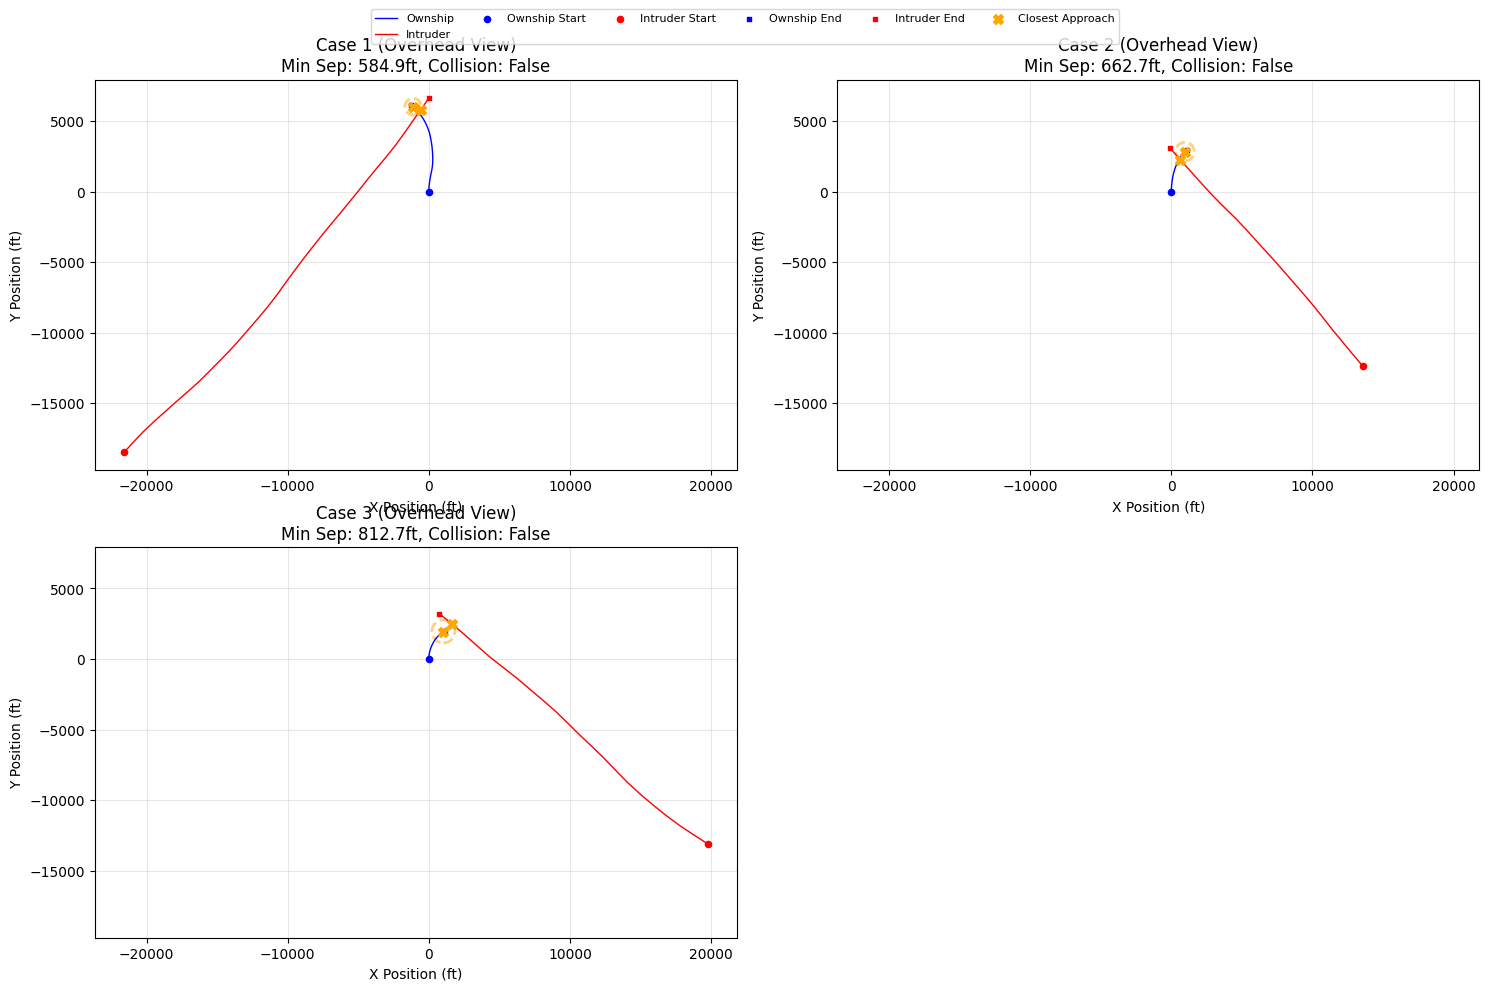

In [5]:
# Plot 2D overhead view of trajectories with minimum min-distances
fig = plt.figure(figsize=(15, 10))
num_examples = 3
ncols = 2
nrows = (num_examples + ncols - 1) // ncols  # Calculate number of rows needed

# Sort by min_separation and take the three with smallest min-distances
sorted_results = sorted(valid_results, key=lambda r: r.min_separation)[:num_examples]

# First pass: collect all x and y ranges to determine common limits
all_x_min, all_x_max = [], []
all_y_min, all_y_max = [], []

for idx in range(num_examples):
    result = sorted_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        all_x_min.extend([ownship_traj[:, 0].min(), intruder_traj[:, 0].min()])
        all_x_max.extend([ownship_traj[:, 0].max(), intruder_traj[:, 0].max()])
        all_y_min.extend([ownship_traj[:, 1].min(), intruder_traj[:, 1].min()])
        all_y_max.extend([ownship_traj[:, 1].max(), intruder_traj[:, 1].max()])

# Calculate common limits with some padding
x_min, x_max = min(all_x_min), max(all_x_max)
y_min, y_max = min(all_y_min), max(all_y_max)
x_range = x_max - x_min
y_range = y_max - y_min
padding = 0.05  # 5% padding

# Initialize handles and labels for legend
handles = []
labels = []

for idx in range(num_examples):
    result = sorted_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ax = fig.add_subplot(nrows, ncols, idx + 1)

        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        # Plot 2D trajectories (x vs y)
        ax.plot(
            ownship_traj[:, 0],
            ownship_traj[:, 1],
            "b",
            label="Ownship",
            linewidth=1,
            # marker="o",
            markersize=3,
        )
        ax.plot(
            intruder_traj[:, 0],
            intruder_traj[:, 1],
            "r",
            label="Intruder",
            linewidth=1,
            # marker="s",
            markersize=3,
        )

        # Mark start points
        ax.scatter(
            ownship_traj[0, 0],
            ownship_traj[0, 1],
            c="blue",
            marker="o",
            s=20,
            label="Ownship Start",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[0, 0],
            intruder_traj[0, 1],
            c="red",
            marker="o",
            s=20,
            label="Intruder Start",
            zorder=5,
        )

        # Mark end points
        ax.scatter(
            ownship_traj[-1, 0],
            ownship_traj[-1, 1],
            c="blue",
            marker="s",
            s=10,
            label="Ownship End",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[-1, 0],
            intruder_traj[-1, 1],
            c="red",
            marker="s",
            s=10,
            label="Intruder End",
            zorder=5,
        )

        # Find and mark closest approach
        ownship_pos = ownship_traj[:, :2]
        intruder_pos = intruder_traj[:, :2]
        distances = np.sqrt(np.sum((ownship_pos - intruder_pos) ** 2, axis=1))
        min_idx = np.argmin(distances)
        ax.scatter(
            ownship_pos[min_idx, 0],
            ownship_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=50,
            label="Closest Approach",
            zorder=6,
        )
        ax.scatter(
            intruder_pos[min_idx, 0],
            intruder_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=50,
            zorder=6,
        )

        # Draw circle at minimum separation
        circle = Circle(
            (ownship_pos[min_idx, 0], ownship_pos[min_idx, 1]),
            result.min_separation,
            fill=False,
            color="orange",
            linestyle="--",
            linewidth=2,
            alpha=0.5,
        )
        ax.add_patch(circle)

        ax.set_xlabel("X Position (ft)")
        ax.set_ylabel("Y Position (ft)")
        ax.set_title(
            f"Case {idx+1} (Overhead View)\n"
            f"Min Sep: {result.min_separation:.1f}ft, "
            f"Collision: {result.collision_occurred}"
        )
        ax.grid(True, alpha=0.3)
        ax.set_aspect("equal")

        # Set the same limits for all subplots
        ax.set_xlim(x_min - padding * x_range, x_max + padding * x_range)
        ax.set_ylim(y_min - padding * y_range, y_max + padding * y_range)

        # Collect handles and labels from first subplot for legend
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()

# Create single legend outside all subplots at the top
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=6, fontsize=8
)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

## Random Forest Regression


In [6]:
# Extract combined trajectories: [x1, y1, theta1, x2, y2, theta2] for each test case
combined_trajectories = []

for result in valid_results:
    if len(result.aircraft_trajectories) >= 2:
        ownship_traj = result.aircraft_trajectories[0]  # (len1, 3) with [x, y, theta]
        intruder_traj = result.aircraft_trajectories[1]  # (len2, 3) with [x, y, theta]

        # Handle different lengths by interpolating to max length
        max_len = max(len(ownship_traj), len(intruder_traj))

        if len(ownship_traj) < max_len:
            # Interpolate ownship trajectory
            t_old = np.linspace(0, 1, len(ownship_traj))
            t_new = np.linspace(0, 1, max_len)
            x1_interp = np.interp(t_new, t_old, ownship_traj[:, 0])
            y1_interp = np.interp(t_new, t_old, ownship_traj[:, 1])
            theta1_unwrapped = np.unwrap(ownship_traj[:, 2])
            theta1_interp = np.interp(t_new, t_old, theta1_unwrapped)
            ownship_traj = np.column_stack([x1_interp, y1_interp, theta1_interp])

        if len(intruder_traj) < max_len:
            # Interpolate intruder trajectory
            t_old = np.linspace(0, 1, len(intruder_traj))
            t_new = np.linspace(0, 1, max_len)
            x2_interp = np.interp(t_new, t_old, intruder_traj[:, 0])
            y2_interp = np.interp(t_new, t_old, intruder_traj[:, 1])
            theta2_unwrapped = np.unwrap(intruder_traj[:, 2])
            theta2_interp = np.interp(t_new, t_old, theta2_unwrapped)
            intruder_traj = np.column_stack([x2_interp, y2_interp, theta2_interp])

        # Stack horizontally: [x1, y1, theta1, x2, y2, theta2]
        combined = np.column_stack([ownship_traj, intruder_traj])
        combined_trajectories.append(combined)

print(f"Extracted {len(combined_trajectories)} combined trajectories")
if len(combined_trajectories) > 0:
    print(f"Combined trajectory shape: {combined_trajectories[0].shape}")

Extracted 1000 combined trajectories
Combined trajectory shape: (2, 6)


In [7]:
# Calculate pairwise Dubins Frechet distance matrix
import os

# Create cache directory if it doesn't exist
os.makedirs("cache", exist_ok=True)

distance_matrix_file = (
    f"cache/dubins_distance_matrix_seed{seed}_size{len(combined_trajectories)}.npy"
)

if os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise Dubins distances...")
    distance_matrix = pairwise_dubins_distances(combined_trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

# Calculate coverage metrics
fixed_bins = 40
iu0 = np.triu_indices(distance_matrix.shape[0], k=1)
d0 = distance_matrix[iu0]
fixed_range = (float(d0.min()), float(d0.max()))

width, uniformity = frechet_coverage(
    distance_matrix, bins=fixed_bins, hist_range=fixed_range
)

print(f"Distance distribution width: {width:.4f}")
print(f"Distance distribution uniformity: {uniformity:.4f}")
print(f"Fixed histogram: bins={fixed_bins}, range={fixed_range}")

Calculating pairwise Dubins distances...
Distance matrix saved to cache/dubins_distance_matrix_seed100_size1000.npy
Distance matrix shape: (1000, 1000)
Distance distribution width: 56591.2756
Distance distribution uniformity: 0.7896
Fixed histogram: bins=40, range=(197.44672695862158, 154311.04093398387)


In [8]:
# Extract features from AcasXuDubinsTestCase
def acasxu_dubins_testcase_to_ndarray(test_case) -> np.ndarray:
    """Convert AcasXuDubinsTestCase to feature array"""
    return np.array(
        [
            test_case.separation,
            test_case.ownship_v,
            test_case.intruder_v,
            test_case.ownship_theta,
            test_case.intruder_placement_angle,
            test_case.intruder_theta,
        ]
    )


# Extract test cases and features
test_cases = [r.test_case for r in valid_results]
features = np.array([acasxu_dubins_testcase_to_ndarray(case) for case in test_cases])
print(f"Features shape: {features.shape}")
print(
    f"Feature names: [separation, ownship_v, intruder_v, ownship_theta, intruder_placement_angle, intruder_theta]"
)

Features shape: (1000, 6)
Feature names: [separation, ownship_v, intruder_v, ownship_theta, intruder_placement_angle, intruder_theta]


In [9]:
# Create pairwise features from test cases
def create_pairwise_features_dubins(
    features: np.ndarray, distance_matrix: np.ndarray
) -> tuple:
    """Create pairwise features for Dubins test cases"""
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (ownship_theta, intruder_placement_angle, intruder_theta)
            # Indices 3, 4, 5 are angular features
            angular_indices = [3, 4, 5]
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features_dubins(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (499500, 16)
Distances shape: (499500,)


In [10]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)

print(f"\nRandom Forest Regression Results:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

Training set: 399600 samples
Test set: 99900 samples

Random Forest Regression Results:
MAE: 9524.65
RMSE: 13747.60
R squared: 0.4246


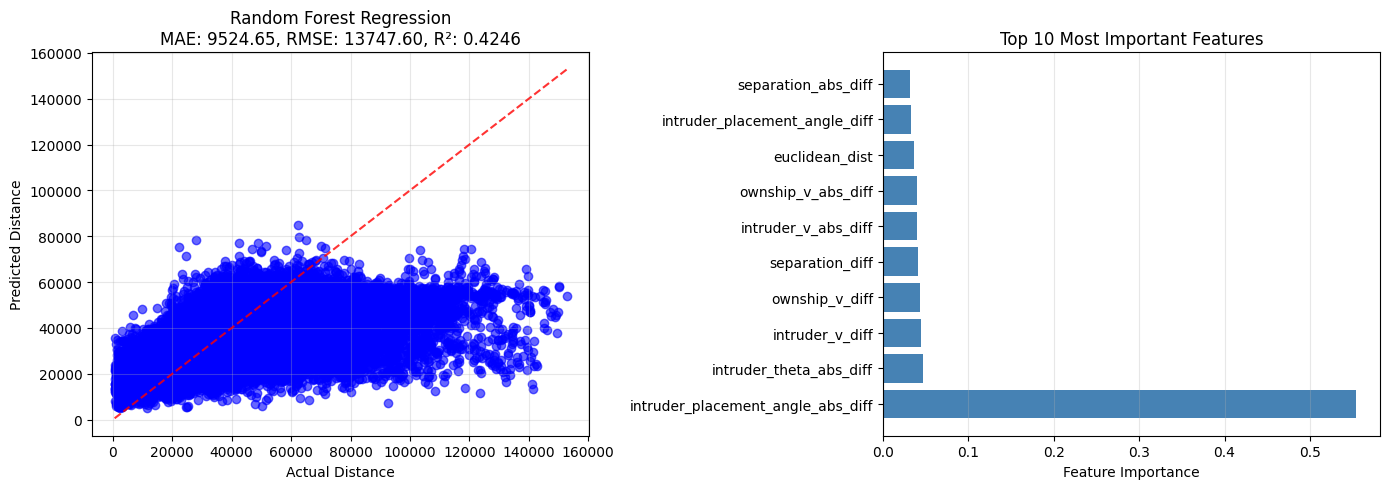


Top 10 Most Important Features:
  1. intruder_placement_angle_abs_diff: 0.5543
  2. intruder_theta_abs_diff: 0.0474
  3. intruder_v_diff: 0.0452
  4. ownship_v_diff: 0.0436
  5. separation_diff: 0.0415
  6. intruder_v_abs_diff: 0.0401
  7. ownship_v_abs_diff: 0.0394
  8. euclidean_dist: 0.0361
  9. intruder_placement_angle_diff: 0.0334
  10. separation_abs_diff: 0.0316


In [11]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: predicted vs actual
ax1.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax1.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax1.set_xlabel("Actual Distance")
ax1.set_ylabel("Predicted Distance")
ax1.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}"
)
ax1.grid(True, alpha=0.3)

# Feature importance
feature_names = [
    "separation_diff",
    "ownship_v_diff",
    "intruder_v_diff",
    "ownship_theta_diff",
    "intruder_placement_angle_diff",
    "intruder_theta_diff",
    "separation_abs_diff",
    "ownship_v_abs_diff",
    "intruder_v_abs_diff",
    "ownship_theta_abs_diff",
    "intruder_placement_angle_abs_diff",
    "intruder_theta_abs_diff",
    "euclidean_dist",
    "ownship_theta_angular_diff",
    "intruder_placement_angle_angular_diff",
    "intruder_theta_angular_diff",
]

rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

# Plot top 10 features
top_n = min(10, len(feature_names))
top_indices = rf_indices[:top_n]
top_importances = rf_importances[top_indices]
top_names = [feature_names[i] for i in top_indices]

ax2.barh(range(top_n), top_importances, color="steelblue")
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_names)
ax2.set_xlabel("Feature Importance")
ax2.set_title("Top 10 Most Important Features")
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i in range(top_n):
    idx = top_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")